## 7. Gaussian Regression class implemented in NumPy
The following code contains a gaussian regression class and a demonstration of its use on a simple 1D dataset

In [1]:
import numpy as np
from numpy.linalg import inv, det
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
class GaussianRegression():
    
    def __init__(self, train_data, train_targets, noise_v=1e-5):
        
        self.train_data = train_data
        self.train_targets = train_targets
        self.noise_v = noise_v
        
        
    def get_k(self, x, z, sig_v, l):
        """Returns covariance kernel"""

        return sig_v**2 * np.exp( - (1 / (2 * l**2)) * ((sum(x.T**2)[:, None] + sum(z.T)**2) - (2 * x @ z.T)))

    def posterior(self, data, sig_v, l):   
        """accepts num_data by num_dimentions array values 
        and returns mean prediction and variance for the data point"""
        
        xs = data
        x = self.train_data
        y = self.train_targets

        K = self.get_k(x, x, sig_v, l) + self.noise_v * np.eye(len(y))
        Ks = self.get_k(x, xs, sig_v, l)
        Kss = self.get_k(xs, xs, sig_v, l)

        mean = (Ks.T @ inv(K)) @ y
        var = Kss - (Ks.T @ inv(K) @ Ks)

        return mean, var

    def log_marginal(self, x, y, sig_v, l):
        """Returns the negative of the log marginal likelyhood for the training data and hyperparameters"""

        K = self.get_k(x, x, sig_v, l) + self.noise_v * np.eye(len(y))

        return 0.5*(y.T @ inv(K) @ y + np.log(det(K)) + len(y) * np.log(2*np.pi))

    def hyp_optimiser(self, sig_vs, ls):
        """Function that finds the minimum of the negative log marginal likelyhood, accepts an array of either a
        single value or multiple hyperparameter initialisation values due to the existence of multiple minima,
        returns the best hyperparameter values found for the given initialisations"""
        
        funs = np.zeros(len(sig_vs) * len(ls))
        results = []
        i = 0
        for sig_v in sig_vs:
            for l in ls:
                result = (minimize(lambda theta: self.log_marginal(self.train_data, self.train_targets, 
                                                              theta[0], theta[1]), 
                                   [sig_v, l], bounds=((1e-5, None), (1e-5, None))))
                funs[i] = result.fun
                results.append(result.x)
                i +=1

        idx = np.argmin(funs)
        sig_opt = results[idx][0]
        l_opt = results[idx][1]

        return sig_opt, l_opt

    def plot(self, data, mean, var, sig_v, l):
        """for 1d data testing, accepts array of the data used for the posterior method"""

        xs = data.reshape(-1)
        mean = mean.reshape(-1)
        fig, ax = plt.subplots(figsize=(10, 6))

        ax.plot(xs, mean, 'k', linewidth=3)
        ax.fill_between(xs, mean + 1.96*np.sqrt(np.diag(var)), mean - 1.96*np.sqrt(np.diag(var)), 
                        color='gray', alpha=0.7)
        ax.scatter(self.train_data, self.train_targets, zorder=3)
        ax.set_title('l = {0:.2f}, sig_v = {1:.2f}, noise = {2}'.format(l, sig_v, self.noise_v))
        plt.show ()

#### genrating some simple training and test data

In [3]:
xs = np.linspace(-5, 5, 101)[:, None] #test points
mu = np.zeros(101) #prior

xt = np.array ([-4, -3, -1, 0, 2])[:, None] #training points
yt = np.array ([-2, 0, 1, 2, -1])[:, None] #training targets

#Initial values for hyperparameter optimisation
ls = np.linspace(0.1, 10, 10)
sig_vs = np.linspace(0.1, 10, 10)

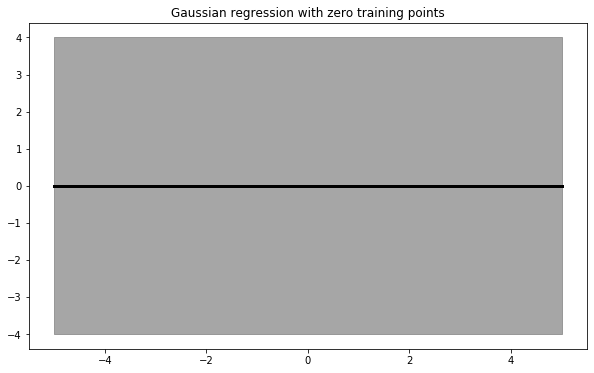

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(xs.reshape(-1), mu, 'k', linewidth=3)
ax.fill_between(xs.reshape(-1), mu + 4, mu - 4, color='gray', alpha=0.7)
ax.set_title('Gaussian regression with zero training points')
plt.show()

#### The resulting model trained with 5 training points and assuming no noise is present in the training data
the shaded area is the 95% confidence interval

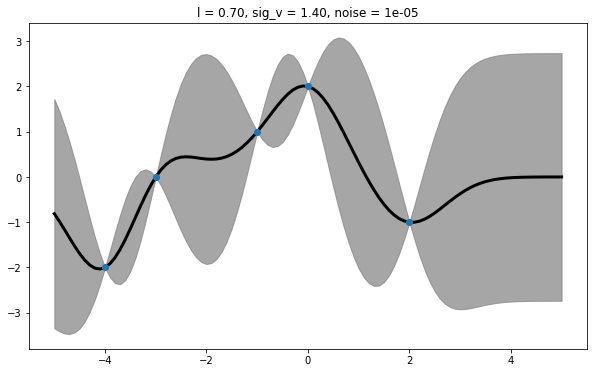

In [5]:
model = GaussianRegression(xt, yt)
sig_opt, l_opt = model.hyp_optimiser(sig_vs, ls)
mean, var = model.posterior(xs, sig_opt, l_opt)
model.plot(xs, mean , var, sig_opt, l_opt)

#### The same data with the added assumption of some noise in the training data

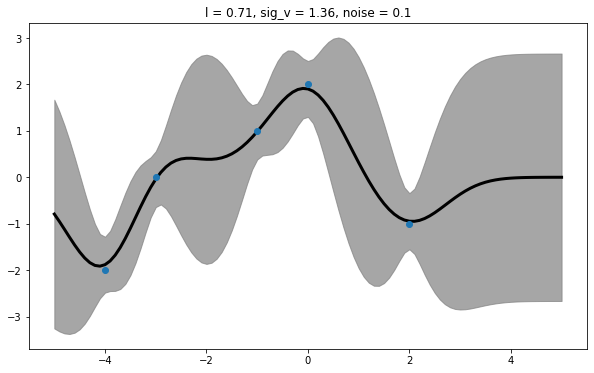

In [6]:
model = GaussianRegression(xt, yt, noise_v=0.1)  #providing the training data
sig_opt, l_opt = model.hyp_optimiser(sig_vs, ls) #optimising hyperparameter values
mean, var = model.posterior(xs, sig_opt, l_opt)  #getting predictions for test data
model.plot(xs, mean , var, sig_opt, l_opt)

adding some additional training points

In [7]:
xt2 = np.array ([-4, -3, -1, 0, 2, -2, 1, 3, 4])[:, None] #training points
yt2 = np.array ([-2, 0, 1, 2, -1, 0.5, 0, -1, -1])[:, None] #training targets

#### With additional training points the variance and and size of the confidence interval reduce

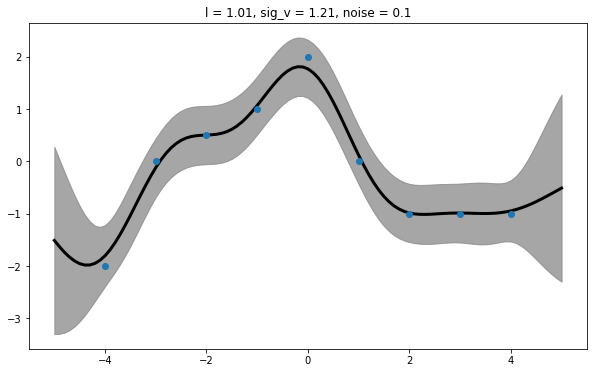

In [8]:
model = GaussianRegression(xt2, yt2, noise_v=0.1)
sig_opt, l_opt = model.hyp_optimiser(sig_vs, ls)
mean, var = model.posterior(xs, sig_opt, l_opt)
model.plot(xs, mean , var, sig_opt, l_opt)